## $\color{red}{\text{TP Wavelets}}$

#### Kilian Berlivet and Maël Le Guillouzic
*TP de TSIA 201 n°1*

### Setup
Installons dans un premier temps les bibliothèques nécessaires au bon fonctionnement du TP, notamment PyWavelets qui permet de générer

In [94]:
!pip install PyWavelets


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import requests
import time

pywt.__version__

'1.7.0'

## Limitation of the Fourier Transform
Instructions:
*   Create a sinusoidal signal of 2.5 seconds of duration. Set up a sampling rate of 20kHz. The signal should be divided in 5 parts of 0.5 seconds of duration each. The signal should have the following frequencies in this order {10 Hz, 30 Hz, 60 Hz, 30 Hz, 10 Hz}.

On va définir une fonction qui réalise l'opération demandée et qui prend en entrée un tableau des fréquences que nous souhaitons voir apparaitre dans notre signal, ainsi que sa durée totale. Ainsi si on souhaite tester avec d'autres paramètres, on pourra le faire simplement en appellant cette fonction.

In [96]:
def changing_sinus(Fe,T,f):
    n_pt = int(Fe*T)
    t = np.linspace(0,T,int(n_pt)) # on créer le vecteur temps de notre signal
    X=np.zeros(n_pt)
    for i in range(len(f)): # on va générer chaque fréquence
        sinus = np.sin(2*np.pi*f[i]*t[i*int(Fe*T/len(f)):(i+1)*int(Fe*T/len(f))])
        X[i*int(Fe*T/len(f)):(i+1)*int(Fe*T/len(f))]=sinus # on ajoute notre sinus généré au bon endroit
    return t,X

Essayons sur un signal tel qu'il est demandé dans l'énoncé.

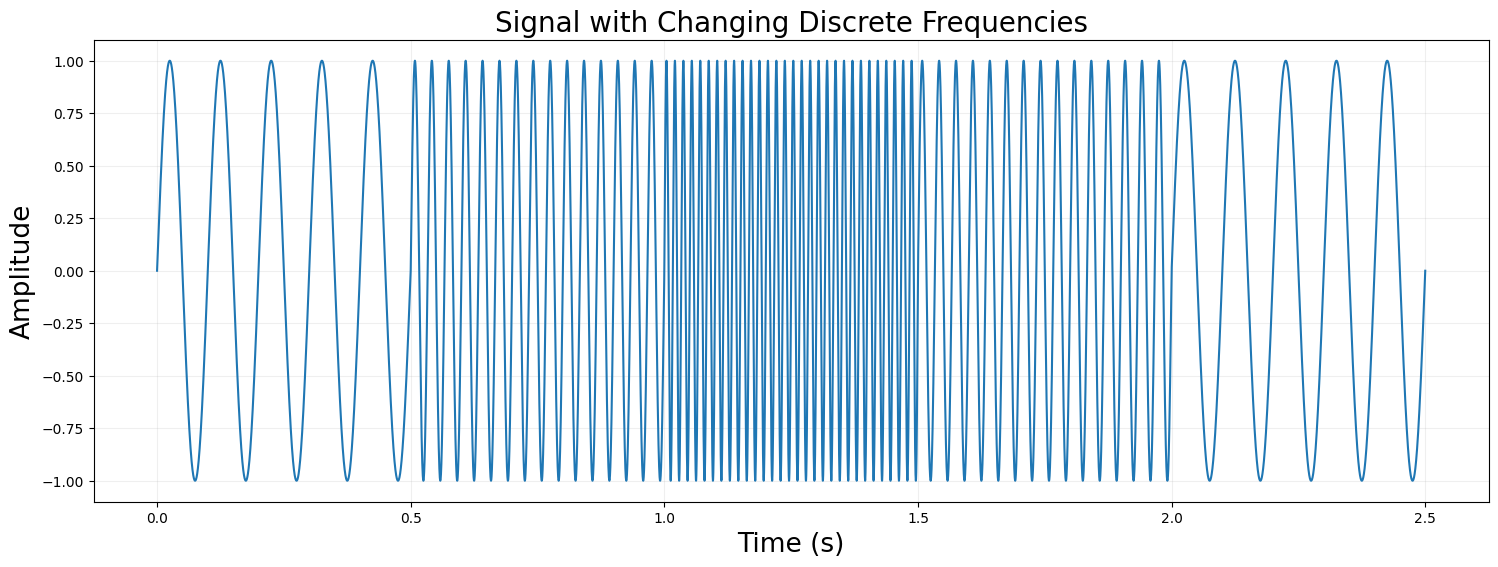

In [97]:
Fe=20000
T=2.5 # en secondes
f=[10,30,60,30,10]

time, signal = changing_sinus(Fe,T,f)

font_size = 20
plt.figure(figsize=(18, 6))
plt.plot(time, signal, linewidth=1.5)
plt.title('Signal with Changing Discrete Frequencies', fontsize=font_size)
plt.xlabel('Time (s)', fontsize=font_size-1)
plt.ylabel('Amplitude', fontsize=font_size-1)
plt.grid(alpha=0.2)

Instructions : 
* Now, you should compute the Discrete Fourier Transform of the signal. You can use any library from Python you prefer. You might need to cut the x-axis in the Fourier transform up to 100 Hz in the visualization. Please check https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html and https://numpy.org/doc/stable/reference/generated/numpy.fft.fftfreq.html

On va calculer la DFT avec np.fft. Nous avons voulu tester dans un second temps du zéro padding, pour mieux observer le comportement de cette transformée de Fourier.

In [98]:
# Calcul de la DFT du signal
DFT = np.fft.fft(signal)
freq = np.fft.fftfreq(len(signal), 1/Fe)

# J'ai voulu tester en réalisant du zero-padding pour mieux observer les variations de cette DFT
add = np.zeros(19*len(signal))
signal_padding = np.concatenate((signal, add))
DFT_zeropadding = np.fft.fft(signal_padding)
freq_zeropadding = np.fft.fftfreq(len(signal_padding), 1/Fe)

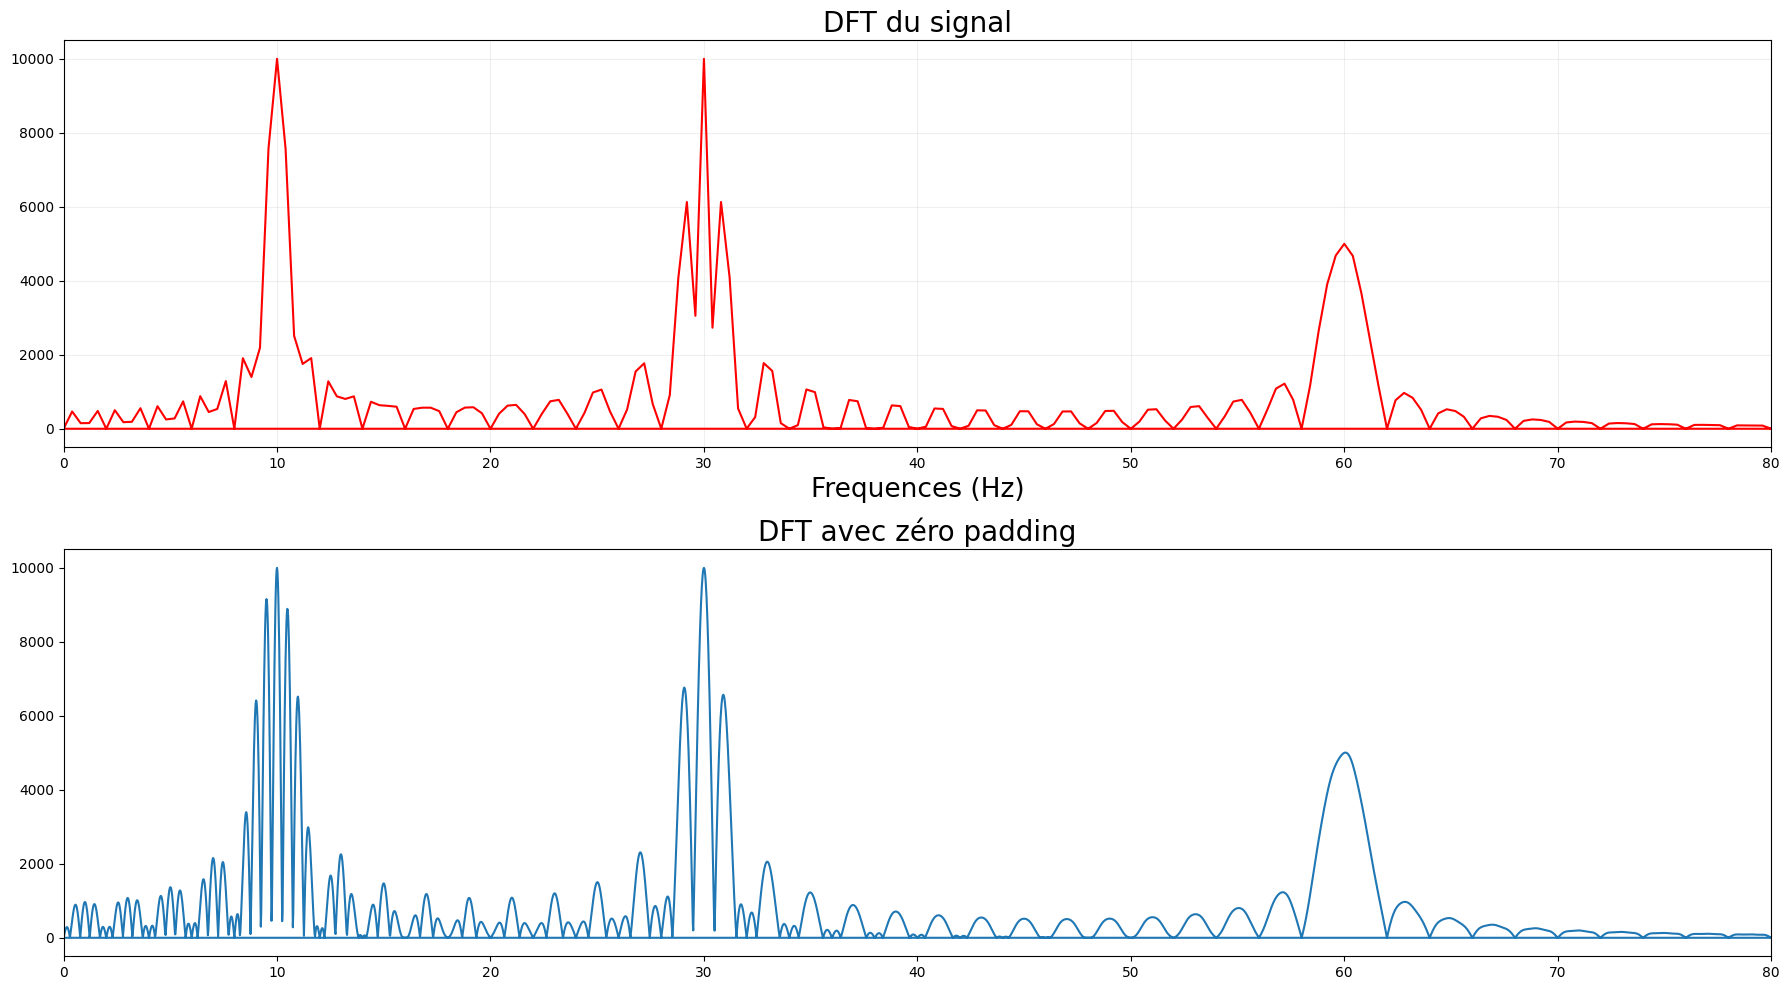

In [99]:
plt.figure(figsize=(18,10))
plt.subplot(211)
plt.plot(freq, np.abs(DFT), linewidth=1.5, color='red')
plt.title('DFT du signal', fontsize=font_size)
plt.xlabel('Frequences (Hz)', fontsize=font_size-1)
plt.xlim(0,80)
plt.grid(alpha=0.2)
plt.subplot(212)
plt.plot(freq_zeropadding, np.abs(DFT_zeropadding), linewidth=1.5)
plt.title('DFT avec zéro padding', fontsize=font_size)
plt.xlim(0,80)
plt.tight_layout()

**QUESTIONS**

1) Does the established sampling rate satisfy the Nyquist-Shannon sampling theorem to avoid aliasing? Please justify.
2) What can you say from the signal looking **only** at the Fourier transform?
3) Can you be certain about the location of some frequency component in the time domain? Why?

**ANSWERS :**

1) The sampling rate is 20KHz and the maximum frequency of the signal is 60Hz. $$2*f_{max}=2*60<20000$$ The Nyquist Shanon sampling theorem is then satisfied to avoid aliasing.

2) Using only the Fourier transform we can easily guess that the signal is at least composed with 10,30 and 60 Hz components. We also see that the amplitude of 10 and 30 Hz are 2 times the amplitude of 60Hz due to the time duration : they appear 2 times 0.5 seconds each instead of 60Hz that appears only one time 0.5 seconds.

3) We have totally lost the time domaine information in the fft because of the definition of the fft itself (it sums over the times). We can not know when it's 10, 30 or 60 Hz , we also can't know that that the signal is not the a product of sinus. We can see that the 10 and 30 Hz are more important than the 60 Hz component.

### **Mother Wavelet**
**Instructions :** As we saw in the course, a wavelet is not just a function but a whole family of functions that satisfy certain requirements. In this part of the TP we're gonna work with the Morlet wavelet defined as follows: $\Psi(t)=k e^{iw_0t}e^{-\frac{1}{2}(\frac{t}{\sigma})^2}$. Please generate a Morlet wavelet in Python **WITHOUT using PyWavelets** with the following parameters:

- Center frequency of the wavelet = 10 Hz
- Sampling rate $\eta$ = 20000 Hz
- $k=\frac{1}{\sqrt{\eta}}$
- $\sigma = 0.1$

You can generate the wavelet between -1 and 1 seconds, so the time duration of the wavelet is 2 seconds. For this part, you just need to generate the real part of the wavelet.

Comme précedemment on définit une fonction qui renvoie une ondelette mère de Morlet. Ainsi, on pourra la réemployer plus tard.

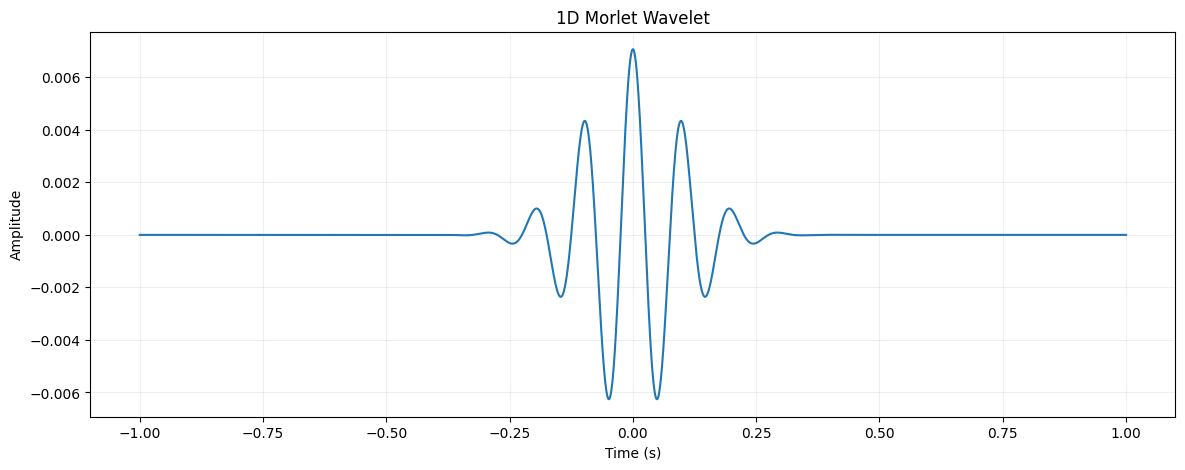

In [100]:
eta = 20000 #fréquence échantillonage
freq_centrale = 10 #fréquence centrale
w_0 = 2*np.pi*freq_centrale 
sigma = 0.1
tps = np.linspace(-1, 1, eta*2) #vecteur temps de notre ondelette

def morlet_constructor(w_0,sigma,tps):
    morlet = (1/np.sqrt(eta))*np.cos(w_0*tps)*np.exp((-1/2)*(tps**2/sigma**2)) 
    return morlet

morlet = morlet_constructor(w_0,sigma,tps)

plt.figure(figsize=(14,5))

plt.plot(tps,morlet)
plt.title('1D Morlet Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(alpha=0.2)

Please show that the mother wavelet we just created satisfies the admissibility and the finite energy conditions.

Pour vérifier cela, on doit :
- Vérifier que la fonction ainsi définie est de moyenne nulle (admissibility condition).
- Vérifier que l'énergie est finie. Cette partie est évidente puisque la fonction qu'on à définie est bornée sur $[-1,1]$ et continue sur cette intervalle. Elle est donc nécessairement d'énergie finie. Même si on l'étendait à $[-\infty,\infty]$, le terme en $\exp(-t^2)$ assure une décroissance en zéro des deux cotés, qui permet de conclure quant à la bonne définition de l'intégrale par croissance comparée.

En executant la cellule ci dessous, on observe bien les deux conditions énoncées ci dessus étant vérifiées.

In [101]:
# admissibility condition
moyenne = np.mean(morlet)
print('Moyenne :', moyenne)
# cette valeur est extrêmement proche de 0, on va donc l'accepter comme nulle.

# energie finie 
energie = np.sum(np.abs(morlet)**2)
print('Energie :', energie)
# la valeur étant finie, la condition d'énergie finie est vérifiée

Moyenne : 2.3708530469514508e-12
Energie : 0.08862047697796217


**Note:** In real life, you have to deal with finite-precision related problems. Therefore, if for the admissibility condition you don't have exactly the value you were expecting for, don't worry.

# **Convolution**

**Instructions :** As we saw in the course, we need a measure of similarity to compute the wavelet transform. We also saw that we can easily compute the shift in time and similarity calculation with the 1-D convolutions.

* Generate a chirp sinusoidal signal from -5 to 5 seconds with an initial frequency of 5 Hz and final frequency of 15 Hz and sampling rate of 20kHz.

De la même manière que précédemment, on définit une fonction `chirp_constructor`, qui prend en entrée une durée, une fréquence de départ et une fréquence finale. Dans notre cas à nous : $$5 \le f \le 15$$

Text(0.5, 0, 'Time')

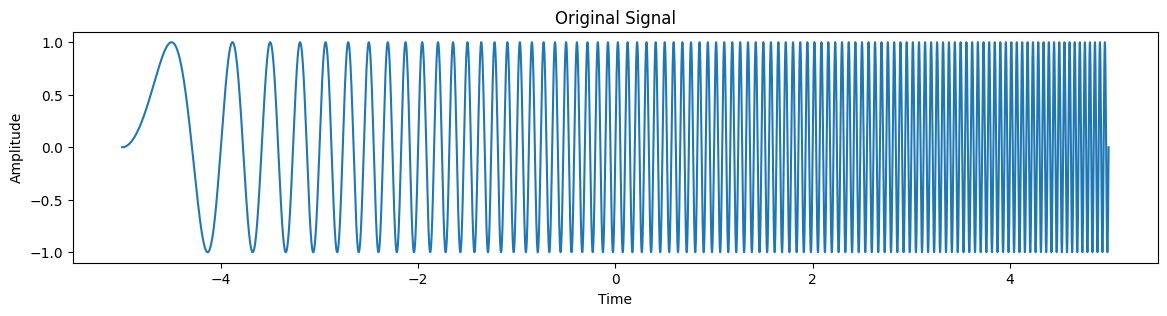

In [102]:
time_signal = np.linspace(-5,5,20000*10)
init_freq = 5
end_freq = 15

def chirp_constructor(time_signal,init_freq,end_freq):
    freqs = np.linspace(init_freq,end_freq,len(time_signal))
    chirp = np.sin(2*np.pi*freqs*time_signal)
    return chirp

chirp = chirp_constructor(time_signal,init_freq,end_freq)

plt.figure(figsize=(14,3))
plt.plot(time_signal, chirp)
plt.title('Original Signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')

**Instructions :** Now create a Morlet wavelet with the following parameters:

* Center frequency of the wavelet = 10 Hz
* Sampling rate $\eta$ = 20000 Hz
* $k=\frac{1}{\sqrt{\eta}}$
* $\sigma = 0.2$
* Duration = 2 seconds


Text(0.5, 0, 'Time')

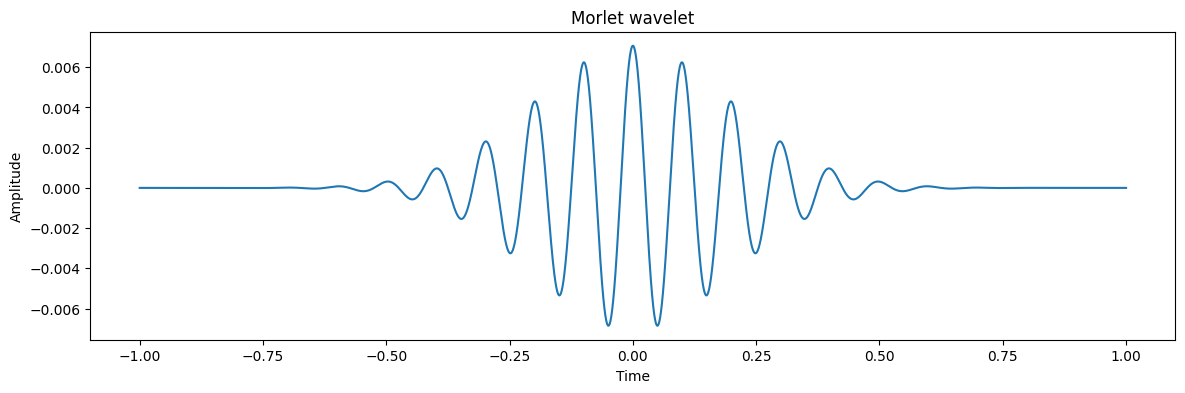

In [103]:
w_1 = 2*np.pi*10
sigma = 0.2
time_signal_morlet = np.linspace(-1,1,eta*2)

def morlet_complex_constructor(w_1,sigma,time_signal):
    morlet = (1/np.sqrt(eta))*np.exp(1j*w_1*time_signal)*np.exp((-1/2)*(time_signal**2/sigma**2)) #le signal est définit complexe cette fois ci.
    return morlet

morlet_wavelet = morlet_complex_constructor(w_1,sigma,time_signal_morlet)

plt.figure(figsize=(14,4))
plt.plot(time_signal_morlet, np.real(morlet_wavelet))
plt.title('Morlet wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time')

Compute the convolution between the signal and $Re(\Psi(t))$. For reference on how to perform convolution with scipy 'convolve' function, please check https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html

Text(0, 0.5, 'Amplitude')

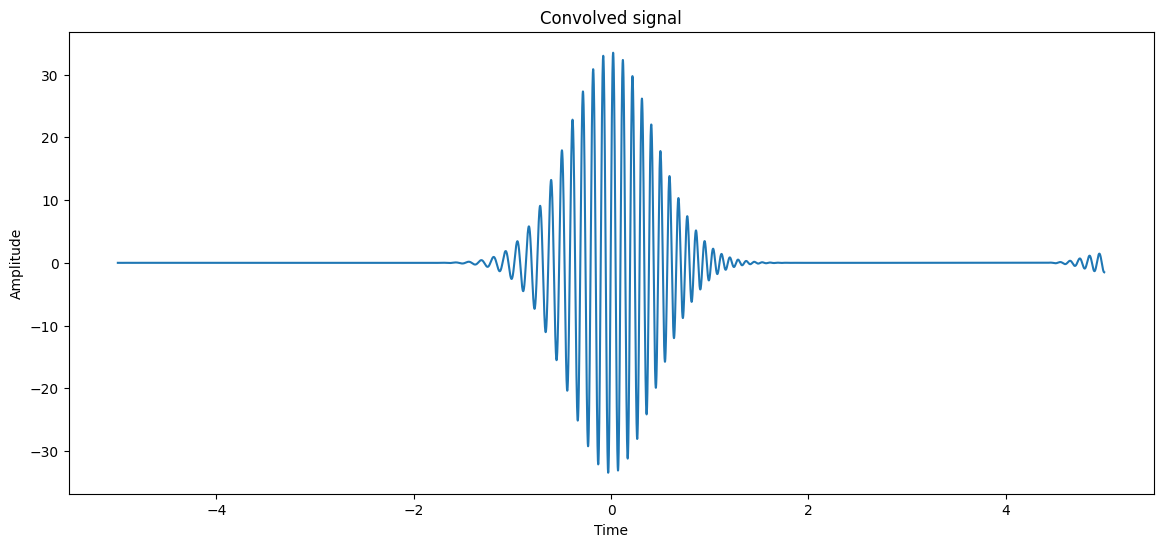

In [104]:
chirp = chirp_constructor(time_signal,init_freq,end_freq)
re_morlet = np.real(morlet_wavelet)

convolved_signal = convolve(chirp,re_morlet,mode="same",method="auto")

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved_signal)
plt.title('Convolved signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

There are some points where the convolution is zero, even in regions of high similarity between the wavelet and the signal. **Is this OK?** If it's not, propose a solution to that.

Ce n'est pas un résultat admetable. Il est du au fait qu'on ne prenne en compte dans notre calcul que la partie réelle de la wavelet de morlet. Il y a donc une **perte d'information**. Pour avoir un meilleur résultat il nous faut la considérer "en entier" avec sa partie imaginaire. Tentons d'implémenter ceci.

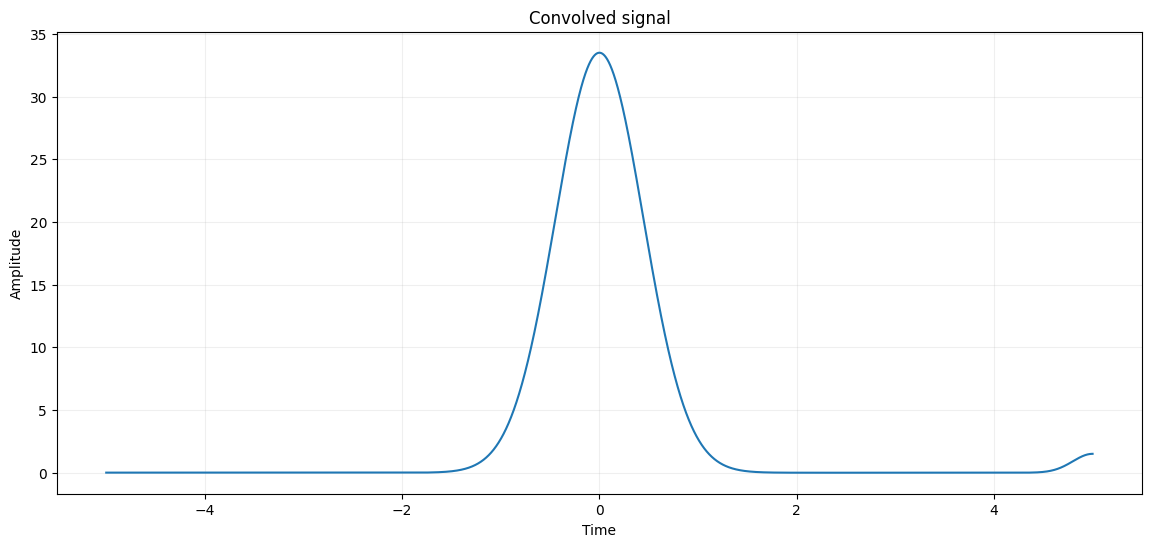

In [105]:
# on re définit notre wavelet et notre signal pour éviter tout conflit
morlet = morlet_complex_constructor(w_1,sigma,time_signal)
chirp = chirp_constructor(time_signal,init_freq,end_freq)
# on sépare la wavelet en partie réelle et partie imaginaire
re_morlet = np.real(morlet)
im_morlet = np.imag(morlet)

# effectuons la convolution de chaque partie
convolved_signal_re = convolve(chirp,re_morlet,mode="same",method="auto")
convolved_signal_im = convolve(chirp,im_morlet,mode="same",method="auto")
# pour obtenir quelque chose de "tracable", on calcule le module
convolved = np.sqrt(convolved_signal_re**2+convolved_signal_im**2)

plt.figure(figsize=(14, 6))
plt.plot(time_signal,convolved)
plt.title('Convolved signal')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.grid(alpha=0.2)

# **Image Compression**
For this part, we'll use the Discrete Wavelet Transform (DWT) implemented as a filter bank to do image compression. The first step is to have an image to compress. For doing so you can use the following piece of code to download an image of Trudy.

In [106]:
url = "https://raw.githubusercontent.com/jhonygiraldo/jhonygiraldo.github.io/main/Trudy_for_compression.jpeg"
response = requests.get(url)

with open('Trudy_for_compression.jpeg', 'wb') as f:
    f.write(response.content)

**Visualize image:** With the following code you can visualize the image. If you're using Google Collab, most probably you already have the open cv library installed. If you're using Jupyter Notebook for example, you'll have to install open cv if it's not already installed.

In [107]:
# Let us define a function for visualizing images
def show_image(image, title='Input Image', font_size=12,fig_size = (10, 10)):
  #A function that uses matplotlib to show grayscale images
  plt.figure(figsize=fig_size)
  plt.imshow(image, cmap='gray')
  plt.title(title, fontsize=font_size)
  plt.axis('off')

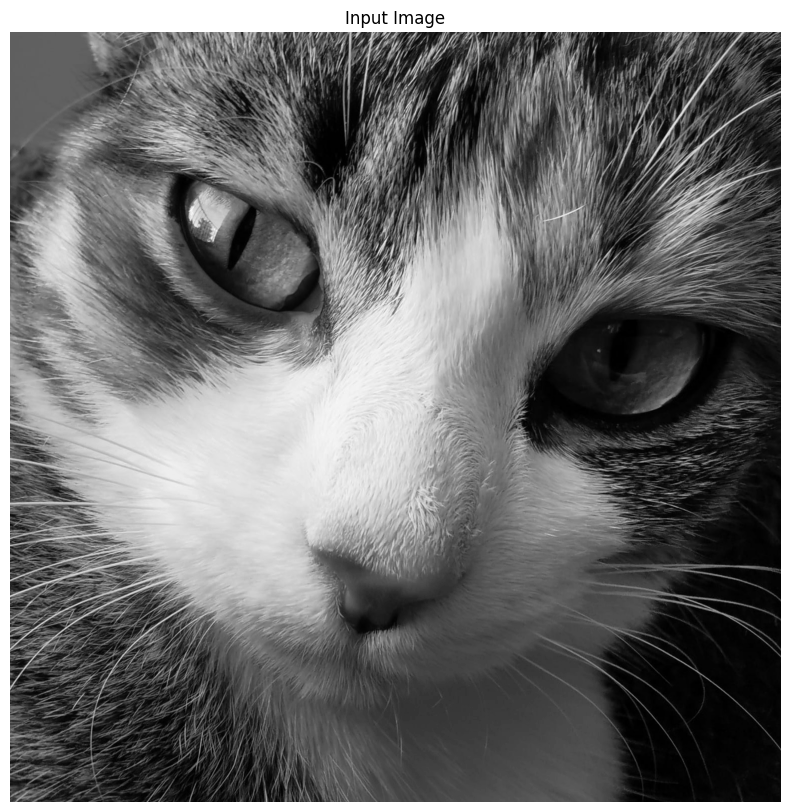

In [108]:
import cv2

# Load your image as a grayscale
input_image = cv2.imread('Trudy_for_compression.jpeg', cv2.IMREAD_GRAYSCALE)
show_image(input_image, 'Input Image')

If you use some wavelet function (Biorthogonal 1.3 in this case), the 1-level 2D wavelet decomposition of our input image is given as follows:

In [109]:
# # You can see a list of wavelet families
import pywt
pywt.families()

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

In [110]:
# For each family, you can list the available wavelets
pywt.wavelist(family='db', kind='all')

['db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38']

Puisque nous avons perdu l'image du TP sur laquelle nous devions commenter un résultat, nous avons reproduit cette image. Ci dessous se trouve donc la décomposition en ondelette de l'image Trudy, avec un treshold appliqué aux 4 images.

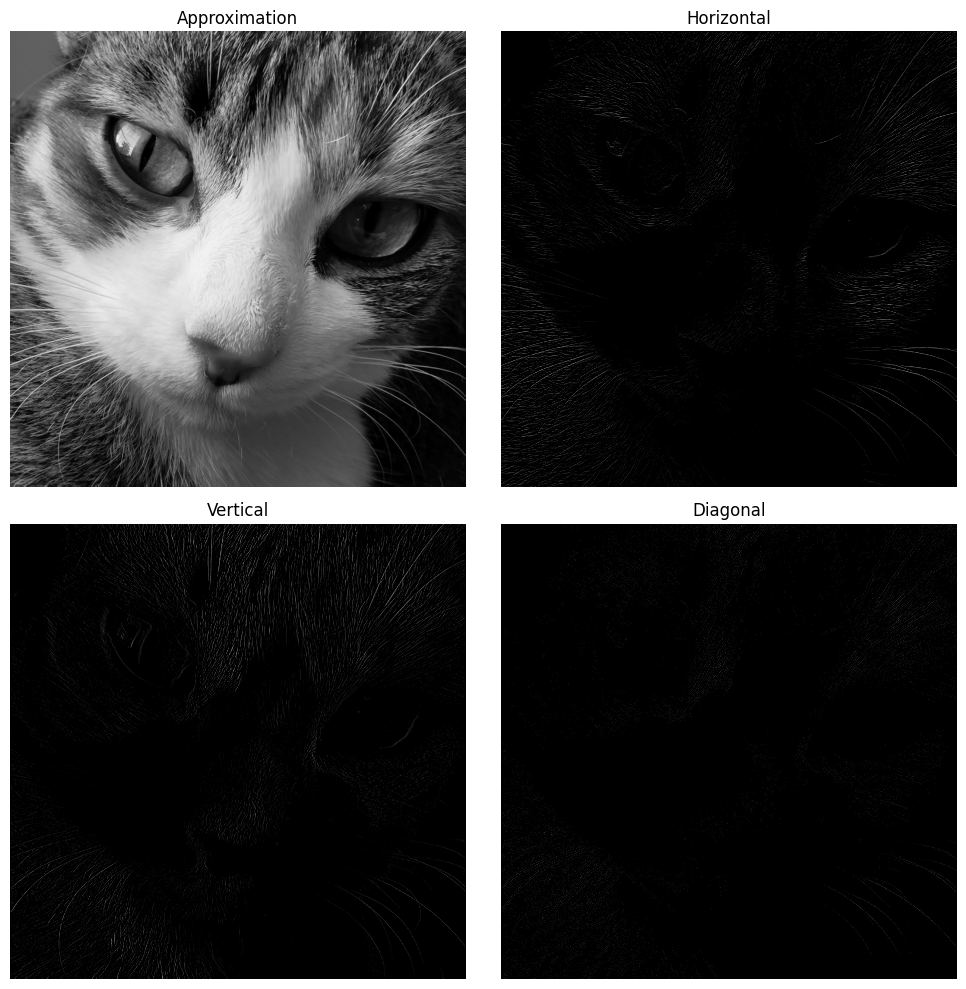

In [111]:
coeffs = pywt.dwt2(input_image, 'bior1.3')
LL,(LH,HL,HH) = coeffs

threshold = 0.01*np.max([LL,LH,HL,HH])
LL_thresh = np.where(np.abs(LL)>threshold,LL,0)
LH_thresh = np.where(np.abs(LH)>threshold,LH,0)
HL_thresh = np.where(np.abs(HL)>threshold,HL,0)
HH_thresh = np.where(np.abs(HH)>threshold,HH,0)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(LL_thresh, cmap='gray', vmin=0, vmax=np.max(LL_thresh))
plt.title("Approximation")
plt.axis('off')

plt.subplot(222)
plt.imshow(LH_thresh, cmap='gray', vmin=0, vmax=np.max(LH_thresh))
plt.title("Horizontal")
plt.axis('off')

plt.subplot(223)
plt.imshow(HL_thresh, cmap='gray', vmin=0, vmax=np.max(HL_thresh))
plt.title("Vertical")
plt.axis('off')

plt.subplot(224)
plt.imshow(HH_thresh, cmap='gray', vmin=0, vmax=np.max(HH_thresh))
plt.title("Diagonal")
plt.axis('off')
plt.tight_layout()
plt.show()


**Instructions :** In the previous image we applied a threshold in the wavelet coefficients for visualization purposes. **Please explain the meaning of each of these 4 images**.

**Answer :**
Les 4 images ci dessus représentent chacune :
- Haut-Gauche : C'est l'image d'origine avec un niveau de détail en moins. On pourrait la traduire par l'image d'origine à laquelle on a enlevé les détails présents dans les 3 autres images
- Haut-Droite : C'est l'image qui conserve les composantes hautes fréquences selon l'axe vertical (c'est à dire les bords). Si on trace sur notre image un trait horizontal par exemple, il apparaitra sur cette image.
- Bas-Gauche : C'est de manière similaire celle qui conserve les détails horizontaux. Si on trace sur notre image un trait vertical par exemple, il apparaitra sur cette image.
- Bas-Droite : Complémentaire aux deux précédentes, elle se charge des détails diagonaux.


Now, you should compute the six-levels 2D wavelet decomposition of the input image with a Daubechies wavelet with six vanishing moments using the PyWavelet library. Please check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2

In [112]:
coeffs_6 = pywt.wavedec2(input_image, 'db1', level=6)
print(f"Nombre de coefficients : {len(coeffs_6)}")

Nombre de coefficients : 7


* Set a threshold of value of 100 and take to zero the values less than that in the 2D wavelet decomposition. **Note:** You should only threshold the outputs of the high-pass filters.



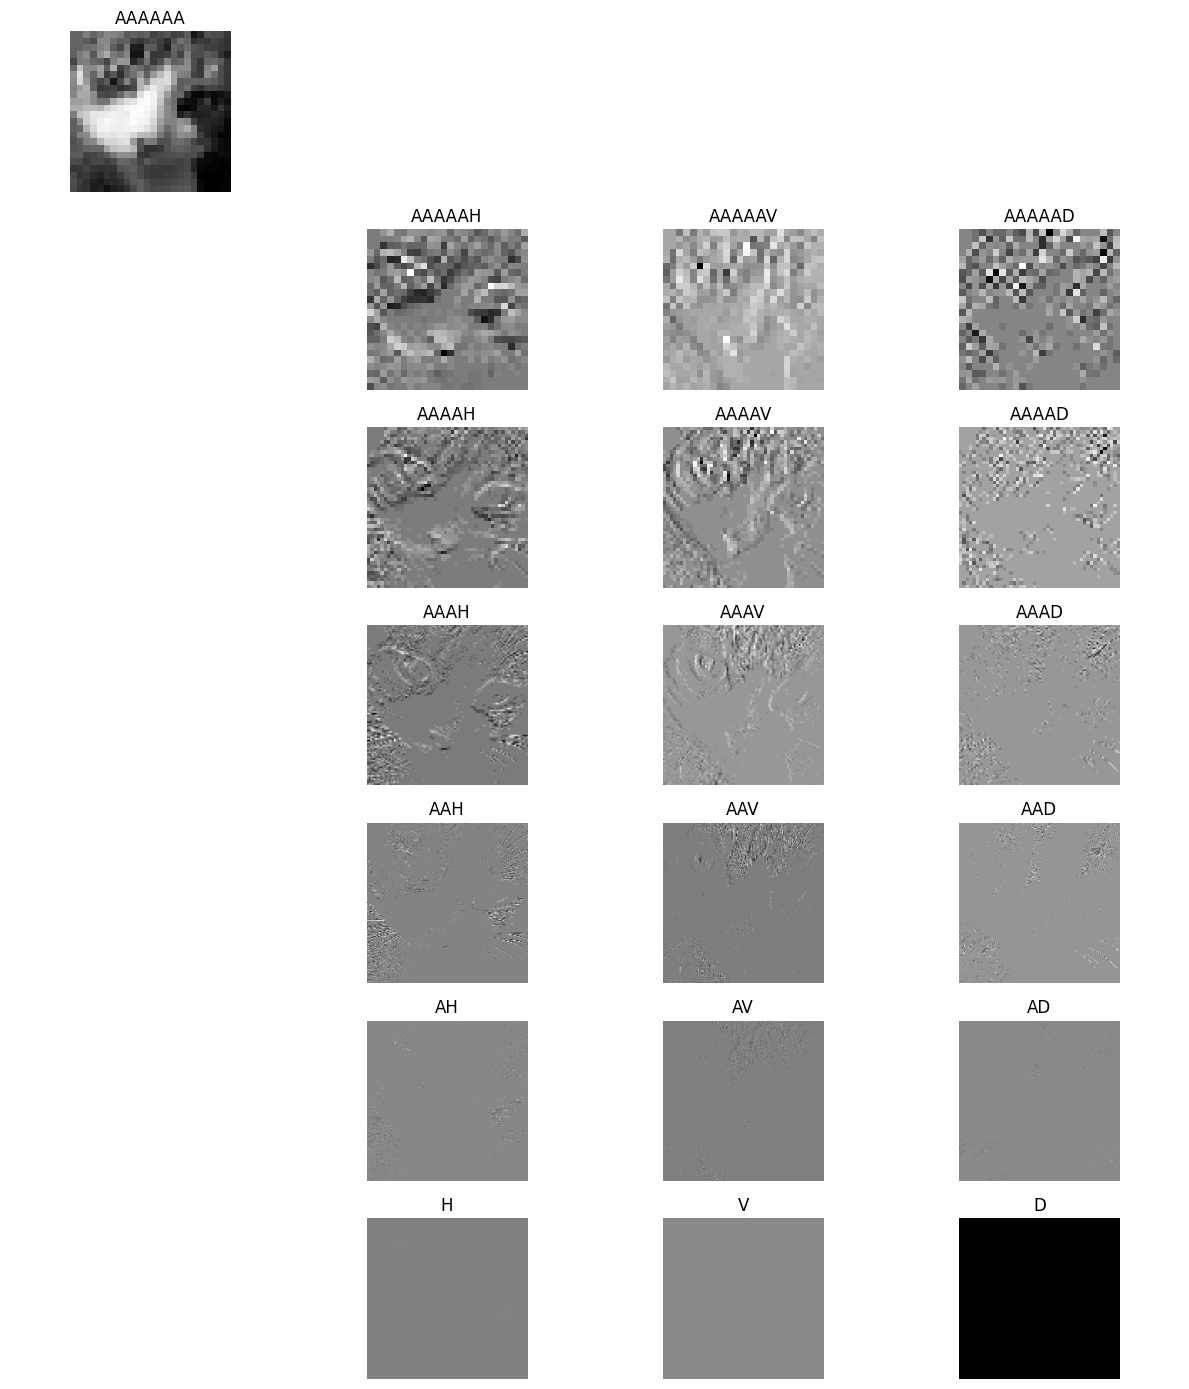

In [113]:
coeffs=coeffs_6.copy()
L=len(coeffs)
threshold = 100

fig, axes = plt.subplots(L, 4, figsize=(12,2*L))
axes = axes if L > 1 else [axes]
titre = ['A', 'H', 'V', 'D']

for i in range(L):
    if i == 0:
        coeff_img = coeffs[0]
        axes[i][0].imshow(coeff_img, cmap='gray')
        axes[i][0].set_title((L-1)*titre[0])
        for ax in axes[i][1:]:
            ax.axis('off')
    else:
        details = list(coeffs[i])
        for k in range(3):
            details[k] = details[k]*(abs(details[k]) > threshold).astype(int)  # Seuillage uniquement des composantes hautes fréquences
            axes[i][k+1].imshow(details[k], cmap='gray')
            axes[i][k+1].set_title((L-i-1)*titre[0]+titre[k+1]) #ajout d'un titre pour savoir de quelle composante parlent t'on
        coeffs[i] = tuple(details)
        axes[i][0].axis('off')


for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

plt.tight_layout()
plt.show()

* Compute the IDWT to reconstruct the image after the "compression". Check https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-reconstruction-using-waverec2 as a reference.

(-0.5, 1531.5, 1530.5, -0.5)

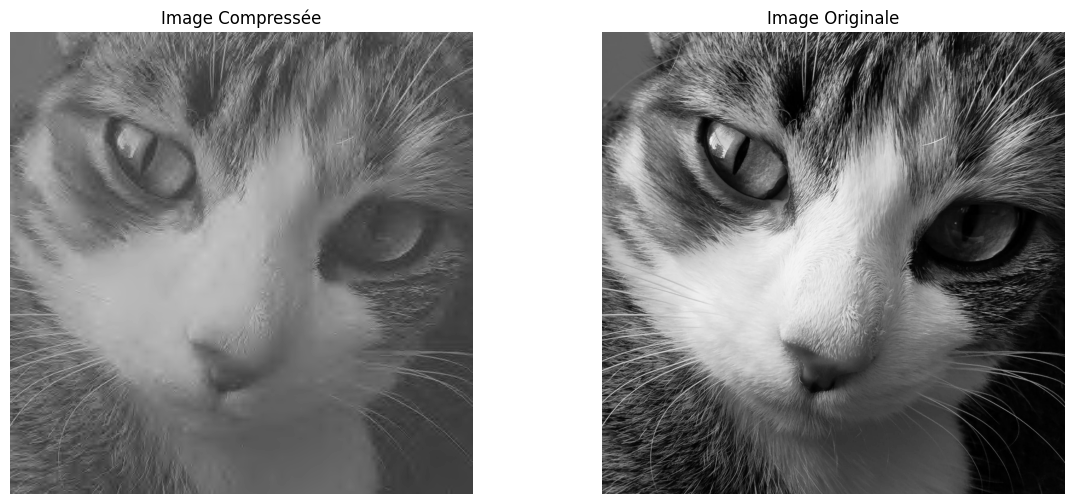

In [114]:
c_img = pywt.waverec2(coeffs, 'db1')

#plot compressed image and original image
fig = plt.figure(figsize=(14,6))
plt.subplot(121)
plt.imshow(compressed_image, cmap='gray')
plt.title("Image Compressée")
plt.axis('off')
plt.subplot(122)
plt.imshow(input_image,cmap='gray')
plt.title("Image Originale")
plt.axis('off')

**Question ?** What's the compression ratio?

**Answer** On peut le calculer avec la cellule suivante, qui consiste simplement à sommer le nombre de pixels non nuls et les multiplier par leur espace mémoire. On obtient ainsi un ratio de compression entre les deux images.

In [115]:
def compression_ratio(input_image,coeffs):
    original_size = input_image.size*input_image.dtype.__sizeof__()
    compressed_size = coeffs[0].size*coeffs[0].dtype.__sizeof__()

    for i in range(1,L):
        coeffs[i] = list(coeffs[i])
        for k in range(0, len(coeffs[i])):
            coeffs[i][k] = coeffs[i][k]*(abs(coeffs[i][k])>threshold).astype(int)
            if np.sum(abs(coeffs[i][k]))>0:
                # print(coeffs[i][k].size*coeffs[i][k].dtype.__sizeof__())
                compressed_size+=coeffs[i][k].size*coeffs[i][k].dtype.__sizeof__()
    return original_size, compressed_size

original_size, compressed_size = compression_ratio(input_image,coeffs)

print(f"Taille de l'image compressée : {compressed_size}")
print(f"Taille de l'image originale : {original_size}")
print('Compression Ratio:', (original_size/compressed_size))

Taille de l'image compressée : 169059360
Taille de l'image originale : 225167232
Compression Ratio: 1.3318826712700202


# **Putting everything together**

In this exercise we'll analyze the Peak Signal to Noise Ration (PSNR) of the compressed images for different thresholds. For doing so, we'll give you the function to compute the PSNR between the original and compressed image.

In [116]:
def psnr(original_image, compressed_image):
    h,w = original_image.shape
    h=min(h,compressed_image.shape[0])
    w=min(w,compressed_image.shape[1])
    original_image=original_image[:h,:w]
    compressed_image=compressed_image[:h,:w]
    
    mse = np.sum(np.abs(original_image-compressed_image)**2)/(h*w)
    return 20* np.log10(255**2/mse)

Now, you have to create a function codec that receives the input image, the wavelet to be used, the number of levels, and the threshold value. This function returns the compressed image and the compression ratio. **Note:** You already did that previously.

In [117]:
def codec(input_image,wavelet='db4',num_levels=6,threshold=100):
  coeffs=pywt.wavedec2(input_image, wavelet, level=num_levels)
  L=len(coeffs)
  
  original_size = input_image.size*input_image.dtype.__sizeof__()
  compressed_size = coeffs[0].size*coeffs[0].dtype.__sizeof__()

  for i in range (1,L):
      coeffs[i] = list(coeffs[i])   
      for k in range(0, len(coeffs[i])):
          coeffs[i][k] = coeffs[i][k]*(abs(coeffs[i][k])>threshold).astype(int)
          if np.sum(abs(coeffs[i][k]))>0:
            compressed_size+=coeffs[i][k].size*coeffs[i][k].dtype.__sizeof__()
      coeffs[i]=tuple(coeffs[i])

  return pywt.waverec2(coeffs, wavelet), (original_size/compressed_size)

Vérifions que notre fonction marche correctement en l'appellant sur l'example précédent.

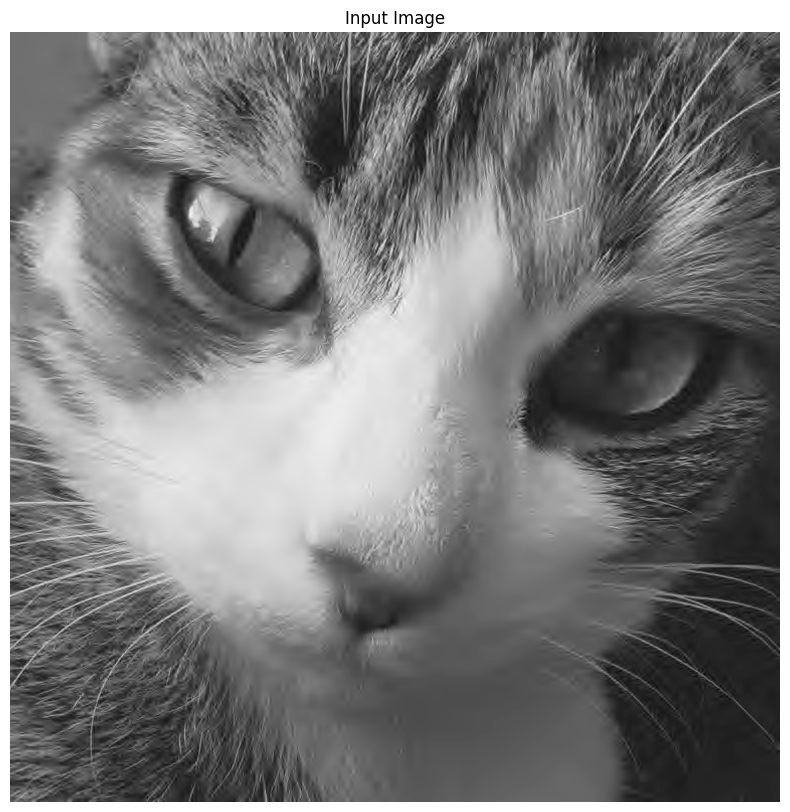

In [118]:
image_codec, ratio_codec = codec(input_image,wavelet='db4',num_levels=6,threshold=100)
show_image(image_codec)

Now, we compare the performance of the 'db4' and the 'bior1.3' wavelets in terms of compression ratio and PSNR for different thresholds.

In [119]:
wavelet_1 = 'db4'
wavelet_2 = 'bior1.3'
thresholds = [5,10,20,40,80,100]
num_levels=6

for thresh in thresholds:
    compressed_image_1, compression_ratio_1 = codec(input_image,wavelet_1,num_levels,thresh)
    compressed_image_2, compression_ratio_2 = codec(input_image,wavelet_2,num_levels,thresh)
    psnr_1 = psnr(input_image,compressed_image_1)   
    psnr_2 = psnr(input_image,compressed_image_2)
    print( '------------------------ Threshold:', thresh,'-----------------------')
    print('Wavelet:', str(wavelet_1).ljust(10), 'Compression Ratio:', str(round(compression_ratio_1,2)).ljust(10), 'PSNR:', round(psnr_1,2))
    print('Wavelet:', str(wavelet_2).ljust(10), 'Compression Ratio:', str(round(compression_ratio_2,2)).ljust(10), 'PSNR:', round(psnr_2,2))
    print()

------------------------ Threshold: 5 -----------------------
Wavelet: db4        Compression Ratio: 0.98       PSNR: 89.14
Wavelet: bior1.3    Compression Ratio: 0.99       PSNR: 88.7

------------------------ Threshold: 10 -----------------------
Wavelet: db4        Compression Ratio: 0.98       PSNR: 78.56
Wavelet: bior1.3    Compression Ratio: 0.99       PSNR: 77.24

------------------------ Threshold: 20 -----------------------
Wavelet: db4        Compression Ratio: 0.98       PSNR: 68.89
Wavelet: bior1.3    Compression Ratio: 0.99       PSNR: 67.0

------------------------ Threshold: 40 -----------------------
Wavelet: db4        Compression Ratio: 0.98       PSNR: 60.7
Wavelet: bior1.3    Compression Ratio: 0.99       PSNR: 58.06

------------------------ Threshold: 80 -----------------------
Wavelet: db4        Compression Ratio: 1.31       PSNR: 53.88
Wavelet: bior1.3    Compression Ratio: 1.32       PSNR: 51.46

------------------------ Threshold: 100 -----------------------


**QUESTION :** Which wavelet is better for the Trudy_for_compression.jpeg image and why?

**ANSWER :** The db4 outperforms the bio1.3 because it has better compression ratio. both of them have about the same PSNR for a given threshold.

## Supplementary Exercises (Optional)
1. Designing and using custom filters with the pyWavelets library
Reference (https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)
2. Propose and explore custom wavelets that achieve equivalent or higher compression ratio on the Trudy image explored previously. **P.S** You are free to explore any approach here.

### Question 2

Pour la question 2, on propose simplement de tester les différents ratios de compression et PSNR pour de nombreuses wavelets usuelles. On en profitera pour mesurer le temps d'execution.
Après execution de notre code ci dessous, il apparait que les meilleurs wavelets sont dans l'ordre :
- bior 2.4
- bior 2.2
- db 5
- coif 2

Les temps d'execution sont similaires, avec une petite avance pour bior2.2

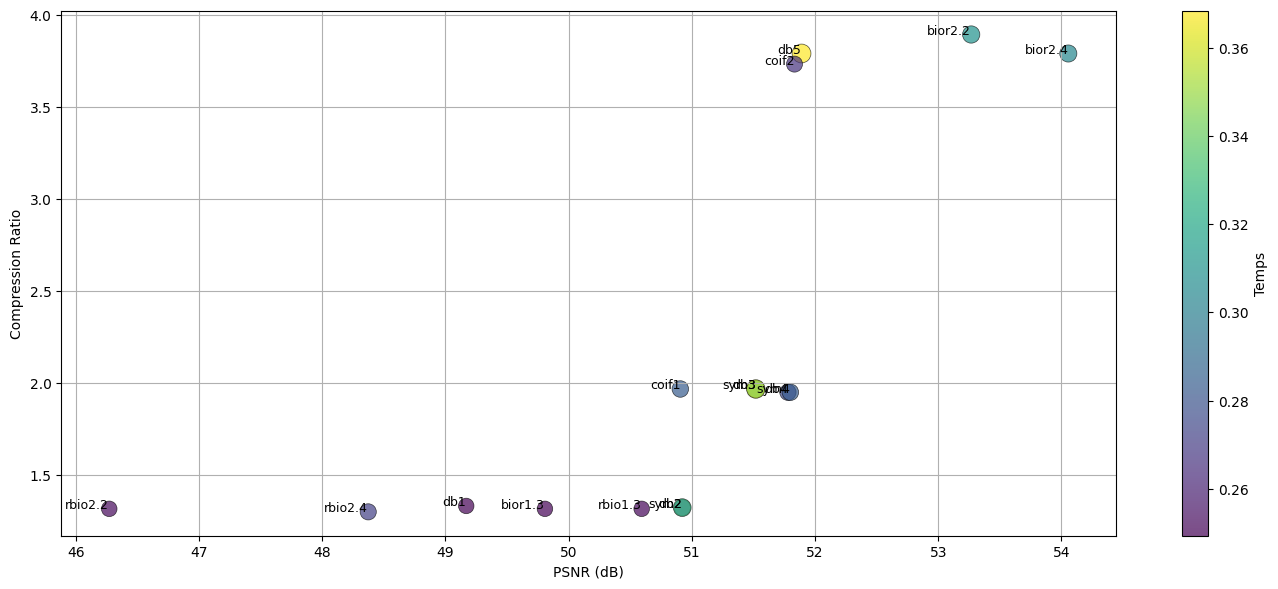

In [130]:
import time

# Liste de wavelets dont on va tester le PSNR + Compression Ratio et le temps de calcul
test_wavelets = ['db1', 'db2', 'db3', 'db4', 'db5', 'sym2', 'sym3', 'sym4', 'coif1', 'coif2', 'bior1.3', 'bior2.2', 'bior2.4', 'rbio1.3', 'rbio2.2', 'rbio2.4']

psnr_data,compression_ratios,times = [],[],[]
start, end = 0, 0

for wavelet in test_wavelets:
    # Mesure du tps de calcul
    start = time.time()
    c_img,ratio = codec(input_image, wavelet, threshold=threshold, num_levels=num_levels)
    psnr_value = psnr(input_image, c_img)
    end = time.time()

    elapsed_time = end-start
    
    psnr_data.append(psnr_value)
    compression_ratios.append(ratio)
    times.append(elapsed_time)

plt.figure(figsize=(14, 6))
scatter = plt.scatter(psnr_data, compression_ratios, s=np.array(times)*500, c=times, cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.5)
for i, wavelet in enumerate(test_wavelets):
        plt.annotate(wavelet, (psnr_data[i], compression_ratios[i]), fontsize=9, ha='right', color='black')


plt.colorbar(scatter, label='Temps')
plt.xlabel('PSNR (dB)')
plt.ylabel('Compression Ratio')
plt.grid(True)
plt.tight_layout()
plt.show()
